# DA for CAE_Linear kol_model.py

In [1]:
import random
from time import perf_counter

import torch
from torch import nn
import torch.nn.functional as F
import numpy
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = True


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)


def set_device():
    """
    Use CPU if cuda device is not available
    setup tf32 for faster GPU computation
    """
    if torch.cuda.device_count() == 0:
        return "cpu"
    torch.set_float32_matmul_precision("high")
    return "cuda"


set_seed(42)
g = torch.Generator()
g.manual_seed(42)
device = set_device()
device

/scratch_dgxl/wy524/miniconda3/envs/irp-env/lib/python3.10/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


'cpu'

In [2]:
from kol_model import KOL_C_FORWARD

forward_model = KOL_C_FORWARD()
forward_model.load_state_dict(torch.load('../../../../results/CAE_Linear/KMG/model_weights/forward_model.pt', weights_only=True, map_location=device))
forward_model.eval()

print(forward_model)

KOL_C_FORWARD(
  (K_S): KOL_K_S(
    (input_proj): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (downsample): Conv2d(16, 16, kernel_size=(4, 4), stride=(4, 4))
    (factorized_layers): ModuleList(
      (0): FactorizedBlock(
        (attn): FactorizedAttention2D(
          (to_qkv): Linear(in_features=16, out_features=48, bias=False)
          (to_out): Linear(in_features=16, out_features=16, bias=True)
          (rope): RoPE2D()
          (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        )
        (mlp): Sequential(
          (0): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=16, out_features=32, bias=True)
          (2): GELU(approximate='none')
          (3): Linear(in_features=32, out_features=16, bias=True)
        )
      )
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (final_proj): Linear(in_features=4096, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
 

In [3]:
import os
import sys
current_directory = os.getcwd()
src_directory = os.path.abspath(os.path.join(current_directory, "..", "..", "..", ".."))
sys.path.append(src_directory)

from src.utils.Dataset import KolDynamicsDataset

foward_step = 12

val_idx = 3

cyl_train_dataset = KolDynamicsDataset(data_path="../../../../data/kolmogorov/RE40_T20/kolmogorov_train_data.npy",
                seq_length = foward_step,
                mean=None,
                std=None)
    
cyl_val_dataset = KolDynamicsDataset(data_path="../../../../data/kolmogorov/RE40_T20/kolmogorov_val_data.npy",
            seq_length = foward_step,
            mean=cyl_train_dataset.mean,
            std=cyl_train_dataset.std)

denorm = cyl_val_dataset.denormalizer()

Loaded Kolmogorov data with shape: (40, 1000, 1, 64, 64)
dataset total samples: 39520
Loaded Kolmogorov data with shape: (10, 1000, 1, 64, 64)
dataset total samples: 9880


In [4]:
groundtruth = cyl_val_dataset.data[val_idx, ...]
groundtruth = torch.from_numpy(groundtruth)

groundtruth.shape

torch.Size([1000, 1, 64, 64])

In [5]:
def visualize_image(image_2d, title='Image', cmap='viridis'):
    if isinstance(image_2d, torch.Tensor):
        image_2d = image_2d.detach().cpu().numpy()

    plt.figure(figsize=(2, 2))
    plt.imshow(image_2d, cmap=cmap)
    plt.colorbar()
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [6]:
import os
import sys
import numpy as np

class UnifiedDynamicSparseObservationHandler:
    def __init__(self, max_obs_ratio: float = 0.15, min_obs_ratio: float = 0.05, seed: int = 42):
        self.max_obs_ratio = max_obs_ratio
        self.min_obs_ratio = min_obs_ratio
        self.seed = seed
        self.fixed_positions = None
        self.max_obs_count = 0
        self.time_masks = {}
        
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
    
    def generate_unified_observations(self, image_shape: tuple, time_steps: list) -> int:
        if len(image_shape) == 3:
            C, H, W = image_shape
        else:
            raise ValueError(f"Expected 3D image shape (C, H, W), got {image_shape}")
        
        total_pixels = C * H * W
        self.max_obs_count = int(total_pixels * self.max_obs_ratio)
        
        self.fixed_positions = torch.randperm(total_pixels)[:self.max_obs_count]
        print(f"Fixed observation positions generated: {self.max_obs_count} positions")
        
        for i, t in enumerate(time_steps):
            obs_ratio = np.random.uniform(self.min_obs_ratio, self.max_obs_ratio)
            num_valid = int(total_pixels * obs_ratio)
            num_valid = min(num_valid, self.max_obs_count)
            
            valid_indices = torch.randperm(self.max_obs_count)[:num_valid]
            
            self.time_masks[i] = {
                'num_valid': num_valid,
                'valid_indices': valid_indices,
                'obs_ratio': obs_ratio
            }
            
            print(f"Time step {t}: {num_valid}/{self.max_obs_count} observations ({obs_ratio:.3f} ratio)")
        
        return self.max_obs_count
    
    def apply_unified_observation(self, full_image: torch.Tensor, time_step_idx: int) -> torch.Tensor:
        if time_step_idx not in self.time_masks:
            raise ValueError(f"Time step index {time_step_idx} not found in masks")
        
        mask_info = self.time_masks[time_step_idx]
        
        flat_image = full_image.flatten()
        fixed_obs = flat_image[self.fixed_positions]
        
        obs_vector = torch.zeros(self.max_obs_count, device=full_image.device)
        valid_indices = mask_info['valid_indices']
        obs_vector[valid_indices] = fixed_obs[valid_indices]
        
        return obs_vector
    
    def create_block_R_matrix(self, base_variance=1e-3):
        R = torch.eye(self.max_obs_count) * base_variance
        return R
    
    def create_unified_R_matrix(self, base_variance: float = 1e-3, 
                               invalid_variance: float = 1.0) -> torch.Tensor:
        R = torch.eye(self.max_obs_count) * invalid_variance
        
        min_valid = min(mask_info['num_valid'] for mask_info in self.time_masks.values())
        
        R[:min_valid, :min_valid] = torch.eye(min_valid) * base_variance
        
        return R

In [7]:
_global_obs_handler = None
_global_time_idx = 0

def update_observation_time_index(time_idx: int):
    global _global_time_idx
    _global_time_idx = time_idx

### DA

In [8]:
import torchda

In [9]:
obs_handler = UnifiedDynamicSparseObservationHandler(
    max_obs_ratio=0.16, 
    min_obs_ratio=0.14, 
    seed=42
)

In [10]:
start_da_end_idxs = (150, 200, 250)

time_obs = [
    start_da_end_idxs[1],
    start_da_end_idxs[1] + 10,
    start_da_end_idxs[1] + 20,
]
gaps = [10] * (len(time_obs) - 1)

full_y_data = [
    cyl_val_dataset.normalize(groundtruth[i+1, ...])
    for i in range(groundtruth.shape[0])
    if i in time_obs
]

full_y_data = torch.cat(full_y_data).to(device)

In [11]:
print(full_y_data.shape)

torch.Size([3, 1, 64, 64])


In [12]:
sample_image_shape = full_y_data[0].shape
max_obs_count = obs_handler.generate_unified_observations(sample_image_shape, range(len(time_obs)))

sparse_y_data = []
for i, full_img in enumerate(full_y_data):
    sparse_obs = obs_handler.apply_unified_observation(full_img, i)
    sparse_y_data.append(sparse_obs)
sparse_y_data = torch.stack(sparse_y_data).to(device)

print(f"Original observation shape: {full_y_data.shape}")
print(f"Dynamic sparse observation shape: {sparse_y_data.shape}")

Fixed observation positions generated: 655 positions
Time step 0: 604/655 observations (0.147 ratio)
Time step 1: 651/655 observations (0.159 ratio)
Time step 2: 633/655 observations (0.155 ratio)
Original observation shape: torch.Size([3, 1, 64, 64])
Dynamic sparse observation shape: torch.Size([3, 655])


In [13]:
def H_unified(x):
    global _global_time_idx, _global_obs_handler
    
    x_reconstructed = forward_model.K_S_preimage(x)
    sparse_obs = _global_obs_handler.apply_unified_observation(
        x_reconstructed.squeeze(), _global_time_idx
    )
    return sparse_obs.unsqueeze(0)

_global_obs_handler = obs_handler

In [14]:
_global_obs_handler = obs_handler

In [15]:
latent_dim = int(forward_model.C_forward.in_features)
B = torch.eye(latent_dim, device=device)

R = obs_handler.create_block_R_matrix(base_variance=1e-3).to(device)

obs_dim = sparse_y_data.shape[1]

print(f"Background covariance B shape: {B.shape}")
print(f"Observation dimension: {obs_dim}")

print(f"R matrix shape: {R.shape}")
print(f"R matrix condition number: {torch.linalg.cond(R):.2e}")
print(f"R matrix rank: {torch.linalg.matrix_rank(R)}")
print(f"R matrix is invertible: {torch.linalg.matrix_rank(R) == R.shape[0]}")

Background covariance B shape: torch.Size([512, 512])
Observation dimension: 655
R matrix shape: torch.Size([655, 655])
R matrix condition number: 1.00e+00
R matrix rank: 655
R matrix is invertible: True


In [16]:
def dmd_warpper(z_t, time_fw=None, *args):
    if time_fw == None:
        if z_t.ndim == 1:
            z_t = z_t.unsqueeze(0)

        z_tp = forward_model.latent_forward(z_t)
        
    else:
        if z_t.ndim == 1:
            z_t = z_t.unsqueeze(0)

        z_tp = torch.empty((time_fw.shape[0], z_t.shape[0], z_t.shape[1]), device=z_t.device)
        
        current_state = forward_model.K_S_preimage(z_t)
        
        for i in range(int(time_fw.shape[0])):
            z_current = forward_model.K_S(current_state)
            z_tp[i] = z_current
            
            if i < int(time_fw.shape[0]) - 1:
                z_next = forward_model.latent_forward(z_current)
                current_state = forward_model.K_S_preimage(z_next)
    
    return z_tp

In [17]:
case_to_run = (
    torchda.CaseBuilder()
    .set_observation_time_steps(time_obs)
    .set_gaps(gaps)
    .set_forward_model(dmd_warpper)
    .set_observation_model(H_unified)
    .set_background_covariance_matrix(B)
    .set_observation_covariance_matrix(R)
    .set_observations(sparse_y_data)
    .set_optimizer_cls(torch.optim.Adam)
    .set_optimizer_args({"lr": 0.5})
    .set_max_iterations(1000)
    .set_algorithm(torchda.Algorithms.Var4D)
    .set_device(torchda.Device.GPU)
    .set_output_sequence_length(1)
)

In [ ]:
outs_4d_da = []

start_time = perf_counter()

current_state = cyl_val_dataset.normalize(groundtruth[start_da_end_idxs[0]])

for i in range(start_da_end_idxs[0], start_da_end_idxs[-1] + 1):
    print(f"Processing step {i}")
    
    z_current = forward_model.K_S(current_state)
    
    if i == start_da_end_idxs[1]:
        update_observation_time_index(0)
        
        case_to_run.set_background_state(z_current.ravel())
        result = case_to_run.execute()
        z_assimilated = result["assimilated_state"]

        z_assimilated = z_assimilated.unsqueeze(0)
        
        intermediate_results = result["intermediate_results"]
        final_cost = intermediate_results["J"][-1]
        print(f"Final cost function: {final_cost}")
        print(f"Number of iterations: {len(intermediate_results['J'])}")
        
        outs_4d_da.append(z_assimilated)
        
        current_state = forward_model.K_S_preimage(z_assimilated.unsqueeze(0))
    else:
        outs_4d_da.append(z_current)
        
        z_next = dmd_warpper(z_current)
        current_state = forward_model.K_S_preimage(z_next)
    
    print("=" * 50)

print(f"Unified dynamic sparse observation 4D-Var time: {perf_counter() - start_time}s")

Processing step 150
Processing step 151
Processing step 152
Processing step 153
Processing step 154
Processing step 155
Processing step 156
Processing step 157
Processing step 158
Processing step 159
Processing step 160
Processing step 161
Processing step 162
Processing step 163
Processing step 164
Processing step 165
Processing step 166
Processing step 167
Processing step 168
Processing step 169
Processing step 170
Processing step 171
Processing step 172
Processing step 173
Processing step 174
Processing step 175
Processing step 176
Processing step 177
Processing step 178
Processing step 179
Processing step 180
Processing step 181
Processing step 182
Processing step 183
Processing step 184
Processing step 185
Processing step 186
Processing step 187
Processing step 188
Processing step 189
Processing step 190
Processing step 191
Processing step 192
Processing step 193
Processing step 194
Processing step 195
Processing step 196
Processing step 197
Processing step 198
Processing step 199


In [19]:
outs_no_4d_da = []
start_time = perf_counter()
with torch.no_grad():
    current_state = cyl_val_dataset.normalize(groundtruth[start_da_end_idxs[0]])
    
    for i in range(start_da_end_idxs[0], start_da_end_idxs[-1] + 1):
        print(i)
        
        z_current = forward_model.K_S(current_state)
        
        outs_no_4d_da.append(z_current)
        
        z_next = forward_model.latent_forward(z_current)
        next_state = forward_model.K_S_preimage(z_next)
        
        current_state = next_state
        print("===============================")
print(f"time elapse for pure dmd: {perf_counter() - start_time}s")

150
151
152
153
154
155
156
157
158


159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
time elapse for pure dmd: 0.8773655602708459s


In [20]:
real_img = groundtruth

len(outs_4d_da), len(outs_no_4d_da), real_img.shape

(101, 101, torch.Size([1000, 1, 64, 64]))

In [21]:
# diffs = []
diffs_da_real_mse = []
diffs_noda_real_mse = []
diffs_da_real_rrmse = []
diffs_noda_real_rrmse = []
diffs_da_real_ssim = []
diffs_noda_real_ssim = []

with torch.no_grad():
    for i, (no_da, da) in enumerate(zip(outs_no_4d_da, outs_4d_da), start=start_da_end_idxs[0]):
        
        da_img = forward_model.K_S_preimage(da).view(1, 64, 64)
        noda_img = forward_model.K_S_preimage(no_da).view(1, 64, 64)

        de_da_img = denorm(da_img)
        de_noda_img = denorm(noda_img)
        
        da_minus_real_img_square = (de_da_img[0] - real_img[i]) ** 2
        noda_minus_real_img_square = (de_noda_img[0] - real_img[i]) ** 2

        diffs_da_real_mse.append(da_minus_real_img_square.mean())
        diffs_noda_real_mse.append(noda_minus_real_img_square.mean())

        diffs_da_real_rrmse.append((da_minus_real_img_square.sum()/((real_img[i]**2).sum())).sqrt())
        diffs_noda_real_rrmse.append((noda_minus_real_img_square.sum()/((real_img[i]**2).sum())).sqrt())

        diffs_da_real_ssim.append(ssim(real_img[i].numpy(), de_da_img[0].numpy(), data_range=1, channel_axis=0))
        diffs_noda_real_ssim.append(ssim(real_img[i].numpy(), de_noda_img[0].numpy(), data_range=1, channel_axis=0))

In [22]:
import pickle

results_data = {
    'diffs_da_real_mse': diffs_da_real_mse,
    'diffs_noda_real_mse': diffs_noda_real_mse,
    'diffs_da_real_rrmse': diffs_da_real_rrmse,
    'diffs_noda_real_rrmse': diffs_noda_real_rrmse,
    'diffs_da_real_ssim': diffs_da_real_ssim,
    'diffs_noda_real_ssim': diffs_noda_real_ssim
}

with open('../../../../results/CAE_Linear/DA/kol_comp_data.pkl', 'wb') as f:
    pickle.dump(results_data, f)

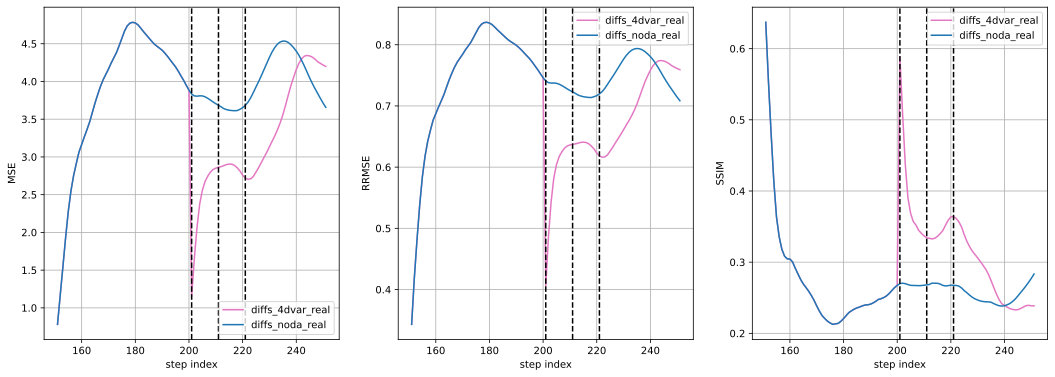

diffs_noda_real_mse[da_idxs[0]]=tensor(3.8332), diffs_noda_real_mse[da_idxs[1]]=tensor(3.6846), diffs_noda_real_mse[da_idxs[2]]=tensor(3.6841)
diffs_da_real_mse[da_idxs[0]]=tensor(1.1521), diffs_da_real_mse[da_idxs[1]]=tensor(2.8634), diffs_da_real_mse[da_idxs[2]]=tensor(2.7198)
diffs_noda_real_rrmse[da_idxs[0]]=tensor(0.7408), diffs_noda_real_rrmse[da_idxs[1]]=tensor(0.7229), diffs_noda_real_rrmse[da_idxs[2]]=tensor(0.7197)
diffs_da_real_rrmse[da_idxs[0]]=tensor(0.4061), diffs_da_real_rrmse[da_idxs[1]]=tensor(0.6373), diffs_da_real_rrmse[da_idxs[2]]=tensor(0.6183)
diffs_noda_real_ssim[da_idxs[0]]=np.float32(0.26983595), diffs_noda_real_ssim[da_idxs[1]]=np.float32(0.26807362), diffs_noda_real_ssim[da_idxs[2]]=np.float32(0.26746657)
diffs_da_real_ssim[da_idxs[0]]=np.float32(0.58819026), diffs_da_real_ssim[da_idxs[1]]=np.float32(0.3341097), diffs_da_real_ssim[da_idxs[2]]=np.float32(0.36409906)


In [23]:
step_idxs = list(range(start_da_end_idxs[0] + 1, start_da_end_idxs[-1] + 2))

_, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].plot(step_idxs, diffs_da_real_mse, color="#e377c2", label="diffs_4dvar_real")
ax[0].plot(step_idxs, diffs_noda_real_mse, color="#1f77b4", label="diffs_noda_real")

ax[1].plot(step_idxs, diffs_da_real_rrmse, color="#e377c2", label="diffs_4dvar_real")
ax[1].plot(step_idxs, diffs_noda_real_rrmse, color="#1f77b4", label="diffs_noda_real")

ax[2].plot(step_idxs, diffs_da_real_ssim, color="#e377c2", label="diffs_4dvar_real")
ax[2].plot(step_idxs, diffs_noda_real_ssim, color="#1f77b4", label="diffs_noda_real")

for i, name in enumerate(["MSE", "RRMSE", "SSIM"]):
    ax[i].set_xlabel("step index")
    ax[i].set_ylabel(name)
    ax[i].grid(True)
    ax[i].legend()
    for x in time_obs:
        ax[i].axvline(x=x+1, color="k", linestyle="--")

plt.show()

da_idxs = [50, 60, 70]
print(f"{diffs_noda_real_mse[da_idxs[0]]=}, {diffs_noda_real_mse[da_idxs[1]]=}, {diffs_noda_real_mse[da_idxs[2]]=}")
print(f"{diffs_da_real_mse[da_idxs[0]]=}, {diffs_da_real_mse[da_idxs[1]]=}, {diffs_da_real_mse[da_idxs[2]]=}")
print(f"{diffs_noda_real_rrmse[da_idxs[0]]=}, {diffs_noda_real_rrmse[da_idxs[1]]=}, {diffs_noda_real_rrmse[da_idxs[2]]=}")
print(f"{diffs_da_real_rrmse[da_idxs[0]]=}, {diffs_da_real_rrmse[da_idxs[1]]=}, {diffs_da_real_rrmse[da_idxs[2]]=}")
print(f"{diffs_noda_real_ssim[da_idxs[0]]=}, {diffs_noda_real_ssim[da_idxs[1]]=}, {diffs_noda_real_ssim[da_idxs[2]]=}")
print(f"{diffs_da_real_ssim[da_idxs[0]]=}, {diffs_da_real_ssim[da_idxs[1]]=}, {diffs_da_real_ssim[da_idxs[2]]=}")

Time observation 0: 200
No DA vs True: 6128.1733
4DVar vs True: 3395.3108
Time observation 1: 210
No DA vs True: 6055.9883
4DVar vs True: 5333.5049
Time observation 2: 220
No DA vs True: 6149.1904
4DVar vs True: 5295.1128
Figure saved to: ../../../../results/CAE_Linear/DA/kol_CAE_Linear.png


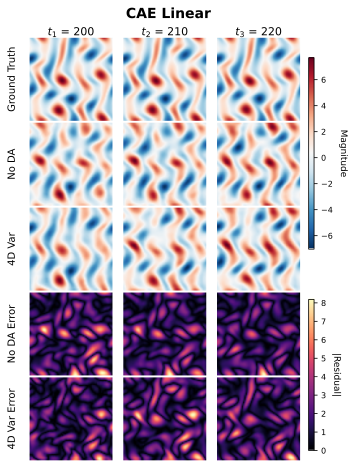

In [24]:
from matplotlib.gridspec import GridSpec

# Set figure parameters
n_times = len(da_idxs)
figsize = (1.5 * n_times + 0.5, 7)
threshold = 0.1
dpi = 300

# Create figure with GridSpec for maximum control
fig = plt.figure(figsize=figsize)
gs = GridSpec(5, n_times, figure=fig, hspace=0.02, wspace=0.01, 
              left=0.1, right=0.88, top=0.90, bottom=0.06)

# Add main title
fig.suptitle('CAE Linear', fontsize=14, fontweight='bold', y=0.96)

# Create subplot array
ax = []
for i in range(5):
    row = []
    for j in range(n_times):
        row.append(fig.add_subplot(gs[i, j]))
    ax.append(row)
ax = np.array(ax)

# Remove all ticks and spines
for axes in ax.flat:
    axes.set_xticks([])
    axes.set_yticks([])
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['bottom'].set_visible(False)
    axes.spines['left'].set_visible(False)

im1 = None
im2 = None

with torch.no_grad():
    for i, da_idx in enumerate(da_idxs):
        # Get ground truth image
        if i == 0:
            img_tensor = real_img[time_obs[i], 0, ...]
        else:
            img_tensor = real_img[time_obs[i], 0, ...]
        
        print(f"Time observation {i}: {time_obs[i]}")
        
        # Plot ground truth image
        im1 = ax[0, i].imshow(img_tensor.reshape(64, 64), cmap="RdBu_r", aspect='equal')
        
        # Get reconstruction results
        no_da = forward_model.K_S_preimage(outs_no_4d_da[da_idx]).cpu()
        da = forward_model.K_S_preimage(outs_4d_da[da_idx]).cpu()

        de_no_da = denorm(no_da)
        de_da = denorm(da)

        image_noda = de_no_da[0, 0, ...]
        image_da = de_da[0, 0, ...]

        # Print difference information
        print(f"No DA vs True: {np.sum(np.abs(img_tensor.numpy() - image_noda.numpy())):.4f}")
        print(f"4DVar vs True: {np.sum(np.abs(img_tensor.numpy() - image_da.numpy())):.4f}")

        # Plot reconstruction images
        ax[1, i].imshow(image_noda.reshape(64, 64), cmap="RdBu_r", aspect='equal')
        ax[2, i].imshow(image_da.reshape(64, 64), cmap="RdBu_r", aspect='equal')
        
        # Calculate and plot residuals
        res_no_da = (img_tensor.reshape(64, 64) - image_noda.reshape(64, 64)).abs()
        res_no_da = torch.where(res_no_da > threshold, res_no_da, 0)
        im2 = ax[3, i].imshow(res_no_da, cmap="magma", aspect='equal')
        
        res_da = (img_tensor.reshape(64, 64) - image_da.reshape(64, 64)).abs()
        res_da = torch.where(res_da > threshold, res_da, 0)
        ax[4, i].imshow(res_da, cmap="magma", aspect='equal')

# Add titles with minimal padding
for i in range(n_times):
    ax[0, i].set_title(f"$t_{i+1}$ = {time_obs[i]}", fontsize=11, pad=2)

# Add row labels
row_labels = ["Ground Truth", "No DA", "4D Var", "No DA Error", "4D Var Error"]
for i, label in enumerate(row_labels):
    ax[i, 0].text(-0.15, 0.5, label, transform=ax[i, 0].transAxes,
                 fontsize=10, ha='right', va='center', rotation=90)

# Add colorbar for viridis (heatmaps)
cax1 = fig.add_axes([0.89, 0.48, 0.015, 0.38])
cbar1 = fig.colorbar(im1, cax=cax1)
cbar1.ax.tick_params(labelsize=8)
cbar1.set_label('Magnitude', rotation=270, labelpad=15, fontsize=9)

# Add colorbar for residual plots
cax2 = fig.add_axes([0.89, 0.08, 0.015, 0.3])
cbar2 = fig.colorbar(im2, cax=cax2)
cbar2.ax.tick_params(labelsize=8)
cbar2.set_label('|Residual|', rotation=270, labelpad=15, fontsize=9)

# Save figure
save_filename = "../../../../results/CAE_Linear/DA/kol_CAE_Linear.png"
plt.savefig(save_filename, dpi=dpi, bbox_inches='tight', pad_inches=0.05)
print(f"Figure saved to: {save_filename}")

plt.show()